In [356]:
import pandas as pd
import datetime as dt
from datetime import date
import numpy as np
import seaborn as sn
import ephem
import pickle
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import style
import tqdm.notebook as tq
style.use('seaborn-dark')

In [357]:
temperature = pd.read_csv(r'Lecture Data\temperature_DK.csv')
cases = pd.read_csv(r'Lecture Data\Municipality_cases_time_series_formatted.csv')
tested = pd.read_csv(r'Lecture Data\Municipality_tested_persons_time_series_formatted.csv')
deaths = pd.read_csv(r'Lecture Data\Deaths_over_time.csv',sep=';')
municipality_code = pd.read_excel(r'Lecture Data\Municipality_codes.xlsx')
municipalities = pd.read_excel(r'Lecture Data\municipalities.xlsx')
co2 = pd.read_csv(r'Lecture Data\co2emisprog_10_28_2021.csv')
co2_1 = pd.read_csv(r'Lecture Data\co2emisprog_10_28_2021 (1).csv')
municipality_coordinates = pd.read_csv(r'Lecture Data\Ikke-navngivet lag.csv')
municipality_income = pd.read_excel(r'Lecture Data\municipality_average_income.xlsx')

In [358]:
municipality_coordinates = municipality_coordinates[municipality_coordinates.styleUrl == '#icon-503-DB4436-nodesc']

In [359]:
municipality_coordinates = municipality_coordinates[['name','longitude','latitude','altitude']]

In [360]:
class municipalityLocation():
    
    def __init__(self, longitude, latitude):
        
        self.observer = ephem.Observer()
        
        self.observer.lon = str(longitude)
        self.observer.lat = str(latitude)
        
        self.sun = ephem.Sun()

    def dayLength(self, t):
        
        try:
    
            self.observer.date = t

            t_rise = ephem.localtime(self.observer.previous_rising(self.sun))
            t_set = ephem.localtime(self.observer.previous_setting(self.sun))

            daylength = (t_set - t_rise).total_seconds()

            return daylength
        
        except:       
            print('An error occured at' + t)

    def dayDiffLengthFunc(self, t):

        len_today = self.dayLength(t)
    
        yesterday = t - dt.timedelta(days=1)
    
        len_yesterday = self.dayLength(yesterday)
    
        dT = len_today - len_yesterday
    
        return dT

In [361]:
municipality_coordinates = municipality_coordinates.rename(columns={'name':'Kommune'})

In [362]:
municipalities = municipalities.merge(municipality_coordinates,on=['Kommune'],how='outer')

In [363]:
co2 = co2.append(co2_1)

In [364]:
co2 = co2.reset_index(drop=True)

In [365]:
co2 = co2.rename(columns={'Minutes5DK':'Date'})

In [366]:
co2['Date'] = pd.to_datetime(co2['Date'], format='%Y-%m-%d %H:%M:%S')

In [367]:
co2 = co2.set_index('Date',drop=True)

In [368]:
co2 = co2.resample('d').sum()

In [369]:
cases.rename(columns={'SampleDate': 'Date'}, inplace=True)
data = cases.set_index('Date',drop=True)

In [370]:
data = data.merge(tested,on=['Date','Kommune'],how='outer')

In [371]:
data = data.merge(municipality_code,on=['Kommune'],how='outer')

In [372]:
deaths.rename(columns={'Dato': 'Date'}, inplace=True)

In [373]:
i = deaths[deaths.Date == 'I alt'].index
deaths = deaths.drop(i)

In [374]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H.%M')

In [375]:
deaths['Date'] = pd.to_datetime(deaths['Date'], format='%Y/%m/%d')

In [376]:
data = data.merge(deaths,on=['Date'],how='outer')

In [377]:
temperature['Time'] = pd.to_datetime(temperature['Time'], format='%Y-%m-%d %H:%M:%S')

In [378]:
temperature['Time'] = pd.to_datetime(temperature.Time).dt.tz_localize(None)

In [379]:
temperature.rename(columns={'Time': 'Date'}, inplace=True)

In [380]:
temperature = temperature.set_index('Date',drop=True)

In [381]:
temperature = temperature.apply(lambda x: x.str.replace(',','.'))

In [382]:
temperature = temperature.apply(pd.to_numeric)

In [383]:
temperature = temperature.resample('d').mean()

In [384]:
data = data.merge(temperature,on=['Date'],how='outer')

In [385]:
data = data.merge(co2,on=['Date'],how='outer')

In [386]:
data = pd.merge(municipalities, data, left_on='Area', right_on='Kommune')

In [387]:
del data['Kommune_y']

In [388]:
data = data.rename(columns={'Kommune_x':'Kommune'})

In [389]:
data

,Kommune,Area,Region,Location,longitude,latitude,altitude,Date,Cases,Tested,Code,Alternative Code,Antal_døde,Temperature,CO2Emission
0,Ærø Kommune,Ærø,Syddanmark,"Ærø Kommune, Syddanmark, DNK",10.406265,54.889526,0.0,2020-02-26,0.0,0.0,492.0,"443, 493",NaN,1.433333,67201.0
1,Ærø Kommune,Ærø,Syddanmark,"Ærø Kommune, Syddanmark, DNK",10.406265,54.889526,0.0,2020-02-27,0.0,0.0,492.0,"443, 493",NaN,1.079167,75074.0
2,Ærø Kommune,Ærø,Syddanmark,"Ærø Kommune, Syddanmark, DNK",10.406265,54.889526,0.0,2020-02-28,0.0,0.0,492.0,"443, 493",NaN,3.275000,49659.0
3,Ærø Kommune,Ærø,Syddanmark,"Ærø Kommune, Syddanmark, DNK",10.406265,54.889526,0.0,2020-03-01,0.0,0.0,492.0,"443, 493",NaN,5.137500,23082.0
4,Ærø Kommune,Ærø,Syddanmark,"Ærø Kommune, Syddanmark, DNK",10.406265,54.889526,0.0,2020-03-02,0.0,0.0,492.0,"443, 493",NaN,5.162500,55074.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72173,Århus Kommune,NaN,NaN,NaN,10.168949,56.162656,0.0,2021-08-26,NaN,NaN,NaN,NaN,NaN,NaN,24922.0
72174,Århus Kommune,NaN,NaN,NaN,10.168949,56.162656,0.0,2021-08-27,NaN,NaN,NaN,NaN,NaN,NaN,23892.0
72175,Århus Kommune,NaN,NaN,NaN,10.168949,56.162656,0.0,2021-08-28,NaN,NaN,NaN,NaN,NaN,NaN,26511.0
72176,Århus Kommune,NaN,NaN,NaN,10.168949,56.162656,0.0,2021-08-29,NaN,NaN,NaN,NaN,NaN,NaN,38026.0


In [390]:
data.dtypes

Kommune                     object
Area                        object
Region                      object
Location                    object
longitude                  float64
latitude                   float64
altitude                   float64
Date                datetime64[ns]
Cases                      float64
Tested                     float64
Code                       float64
Alternative Code            object
Antal_døde                 float64
Temperature                float64
CO2Emission                float64
dtype: object

In [391]:
data = data.set_index('Date',drop=True)

In [392]:
data = data.drop(data[pd.isnull(data.index)].index)

In [393]:
daylength_dict = {}
for municipality in tq.tqdm(data.Kommune.unique()):
    
    try:
    
        location = municipality_coordinates[municipality_coordinates.Kommune == municipality]

        municipality_location = municipalityLocation(location.longitude.values[0],location.latitude.values[0])

        vfunc = np.vectorize(municipality_location.dayLength)  
        daylength = vfunc(np.unique(data.index.date))
    
    except:
        
        daylength = np.nan
    
    daylength_dict[municipality] = daylength

  0%|          | 0/117 [00:00<?, ?it/s]

In [394]:
dayelenghts_municipality = pd.DataFrame(daylength_dict)

In [395]:
dayelenghts_municipality['Date'] = np.unique(data.index.date)

In [396]:
dayelenghts_municipality = dayelenghts_municipality.set_index('Date',drop=True)

In [397]:
daylenght_municipality = dayelenghts_municipality.stack().reset_index(level=1, name='Daylength').rename(columns={'level_1':'Kommune'})

In [398]:
daylenght_municipality = daylenght_municipality.reset_index()

In [399]:
daylenght_municipality['Date'] = pd.to_datetime(daylenght_municipality['Date'], format='%Y-%m-%d')

In [400]:
data = data.merge(daylenght_municipality,on=['Kommune','Date'])

In [401]:
municipality_income

,Kommune,Gennemsnit for alle personer (kr.)
0,Landsdel Byen København,353203
1,København,342385
2,Frederiksberg,412387
3,Dragør,437574
4,Tårnby,339955
...,...,...
104,Morsø,296882
105,Rebild,345560
106,Thisted,306245
107,Vesthimmerlands,302365


In [402]:
data = pd.merge(data,municipality_income, left_on='Area',right_on='Kommune',how='outer')

In [403]:
del data['Kommune_y']

In [404]:
data = data.rename(columns={'Kommune_x':'Kommune'})

In [406]:
data = data.set_index('Date',drop=True)

In [407]:
data = data.sort_values(by='Date')

<AxesSubplot:>

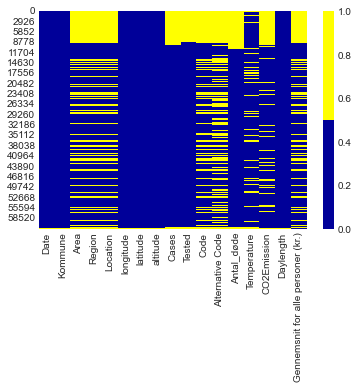

In [416]:
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sn.heatmap(data.isnull(), cmap=sn.color_palette(colours))

Introducing NaN values

In [411]:
data = data.reset_index()

In [413]:
data['Temperature'] = data['Temperature'].sample(frac=0.85)

In [415]:
data['CO2Emission'] = data['CO2Emission'].sample(frac=0.85)

In [425]:
data_dirty = data

In [426]:
picklefile = open(r'dirty_data', 'wb')
pickle.dump(data_dirty, picklefile)
picklefile.close()

# Preliminary Data Visualization

In [423]:
df1 = data.drop(['altitude'], axis=1)

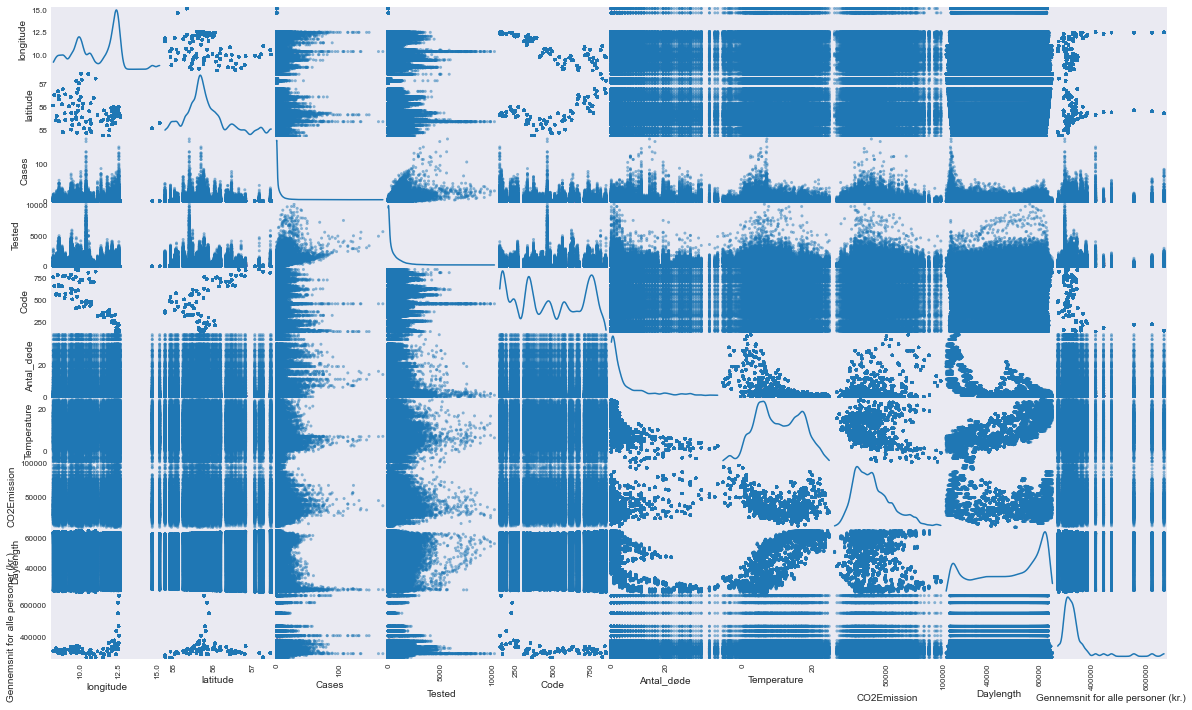

In [424]:
scatter_matrix(df1, figsize=(20, 12), diagonal="kde");

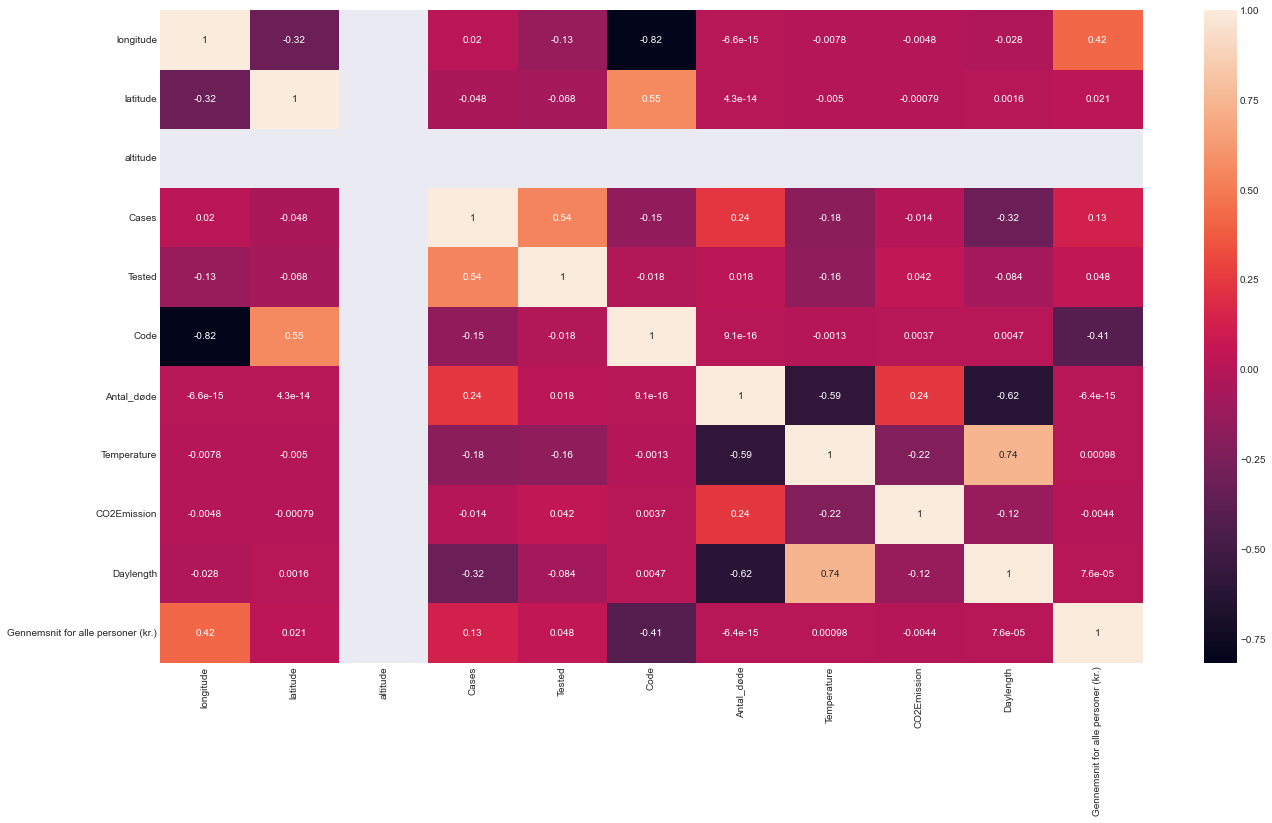

In [420]:
corrMatrix = data.corr()

fig, ax = plt.subplots(figsize=(22,12))  
sn.heatmap(corrMatrix, annot=True)
plt.show()

C:\Users\danho\AppData\Local\Temp\1/ipykernel_12796/3346438594.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


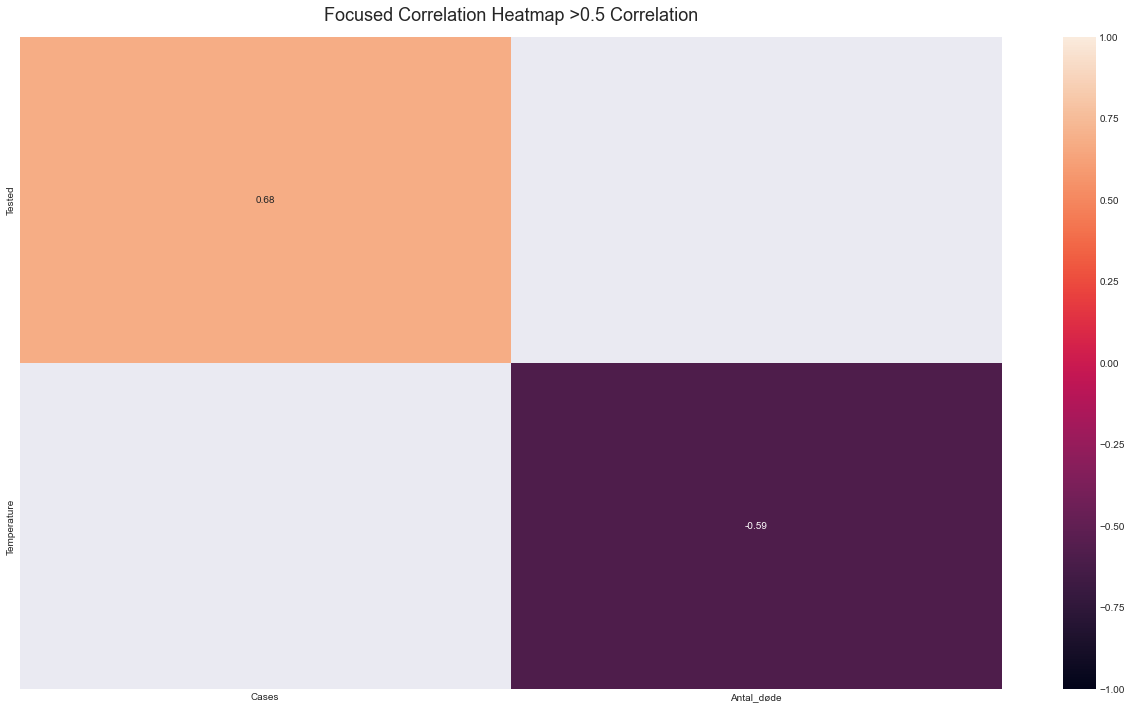

In [178]:
corr = corrMatrix

mask = np.triu(np.ones_like(corr, dtype=np.bool))
cut_off = 0.5  # only show cells with abs(correlation) at least this value
extreme_1 = 0.75  # show with a star
extreme_2 = 0.85  # show with a second star
extreme_3 = 0.90  # show with a third star
mask |= np.abs(corr) < cut_off
corr = corr[~mask]  # fill in NaN in the non-desired cells

remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.2f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corr.to_numpy()]

fig, ax = plt.subplots(figsize=(22,12)) 
heatmap = sn.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='')
heatmap.set_title('Focused Correlation Heatmap >0.5 Correlation', fontdict={'fontsize': 18}, pad=16)
plt.show()